In [38]:
#!/usr/bin/env python3
"""
Helper functions for plotting IR and Raman spectra from compute_ir_raman.py output.

Usage:
    from plot_ir_raman import load_spectra, plot_ir, plot_raman, plot_combined
    
    # Load data
    data = load_spectra('ir_raman.npz')
    
    # Plot IR
    plot_ir(data['ir_frequencies'], data['ir_intensity'], 
            save_path='ir_spectrum.png', freq_range=(0, 4500))
    
    # Plot Raman
    plot_raman(data['raman_frequencies'], 
               data['raman_intensity_isotropic'],
               data['raman_intensity_anisotropic'],
               save_path='raman_spectrum.png')
    
    # Plot both
    plot_combined(data, save_path='combined_spectra.png')
"""

from __future__ import annotations

from pathlib import Path
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks


def load_spectra(npz_path: Path | str) -> dict:
    """
    Load IR/Raman spectra from NPZ file.
    
    Parameters
    ----------
    npz_path : Path or str
        Path to NPZ file created by compute_ir_raman.py
    
    Returns
    -------
    dict
        Dictionary containing frequencies, intensities, etc.
    """
    data = np.load(npz_path)
    return {key: data[key] for key in data.keys()}


def find_peaks_in_spectrum(
    frequencies: np.ndarray,
    intensity: np.ndarray,
    min_height: float = 0.01,
    min_prominence: float = 0.01,
    min_distance: int = 10,
    freq_range: Optional[Tuple[float, float]] = None,
) -> Tuple[np.ndarray, dict]:
    """
    Find peaks in spectrum.
    
    Parameters
    ----------
    frequencies : np.ndarray
        Frequency array (cm⁻¹)
    intensity : np.ndarray
        Intensity array
    min_height : float
        Minimum peak height (relative to max)
    min_prominence : float
        Minimum peak prominence
    min_distance : int
        Minimum distance between peaks (in frequency points)
    freq_range : tuple, optional
        (min_freq, max_freq) to restrict search
    
    Returns
    -------
    peaks : np.ndarray
        Indices of peaks
    properties : dict
        Peak properties (heights, prominences, etc.)
    """
    if freq_range is not None:
        mask = (frequencies >= freq_range[0]) & (frequencies <= freq_range[1])
        freq_subset = frequencies[mask]
        intensity_subset = intensity[mask]
    else:
        freq_subset = frequencies
        intensity_subset = intensity
    
    # Normalize for peak finding
    max_intensity = np.max(intensity_subset)
    if max_intensity > 0:
        intensity_normalized = intensity_subset / max_intensity
        height_threshold = min_height
        prominence_threshold = min_prominence
    else:
        return np.array([]), {}
    
    peaks, properties = find_peaks(
        intensity_normalized,
        height=height_threshold,
        prominence=prominence_threshold,
        distance=min_distance,
    )
    
    return peaks, properties


def plot_ir(
    frequencies: np.ndarray,
    intensity: np.ndarray,
    save_path: Optional[Path | str] = None,
    freq_range: Tuple[float, float] = (0, 4500),
    title: str = "IR Spectrum",
    label: Optional[str] = None,
    color: str = "#2E86AB",
    linewidth: float = 1.5,
    alpha: float = 0.8,
    show_peaks: bool = True,
    peak_threshold: float = 0.05,
    figsize: Tuple[float, float] = (12, 6),
    dpi: int = 300,
    ax: Optional[plt.Axes] = None,
) -> plt.Figure:
    """
    Plot IR spectrum.
    
    Parameters
    ----------
    frequencies : np.ndarray
        Frequency array (cm⁻¹)
    intensity : np.ndarray
        Intensity array
    save_path : Path or str, optional
        Path to save figure
    freq_range : tuple
        (min_freq, max_freq) to plot
    title : str
        Plot title
    label : str, optional
        Label for legend
    color : str
        Line color
    linewidth : float
        Line width
    alpha : float
        Transparency
    show_peaks : bool
        Whether to mark peaks
    peak_threshold : float
        Minimum relative intensity for peak marking
    figsize : tuple
        Figure size (width, height)
    dpi : int
        Resolution for saved figure
    ax : plt.Axes, optional
        Existing axes to plot on
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure object
    """
    mask = (frequencies >= freq_range[0]) & (frequencies <= freq_range[1])
    freq_plot = frequencies[mask]
    intensity_plot = intensity[mask]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure
    
    ax.plot(freq_plot, intensity_plot, color=color, linewidth=linewidth, 
            alpha=alpha, label=label)
    ax.fill_between(freq_plot, 0, intensity_plot, color=color, alpha=0.3)
    
    # Find and mark peaks
    if show_peaks:
        peaks, props = find_peaks_in_spectrum(
            frequencies, intensity, min_height=peak_threshold, freq_range=freq_range
        )
        if len(peaks) > 0:
            peak_freqs = frequencies[mask][peaks]
            peak_intensities = intensity[mask][peaks]
            ax.scatter(peak_freqs, peak_intensities, color='red', s=50, 
                      zorder=5, marker='v', label='Peaks')
            
            # Label top peaks
            if len(peaks) > 0:
                top_n = min(5, len(peaks))
                top_indices = np.argsort(peak_intensities)[-top_n:]
                for idx in top_indices:
                    ax.annotate(
                        f'{peak_freqs[idx]:.0f}',
                        xy=(peak_freqs[idx], peak_intensities[idx]),
                        xytext=(5, 10),
                        textcoords='offset points',
                        fontsize=9,
                        color='red',
                        weight='bold',
                    )
    
    ax.set_xlabel('Frequency (cm⁻¹)', fontsize=12, weight='bold')
    ax.set_ylabel('IR Intensity (normalized)', fontsize=12, weight='bold')
    ax.set_title(title, fontsize=14, weight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(freq_range)
    
    if label:
        ax.legend(fontsize=10, framealpha=0.9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"✅ Saved IR spectrum to {save_path}")
    
    return fig


def plot_raman(
    frequencies: np.ndarray,
    intensity_isotropic: Optional[np.ndarray] = None,
    intensity_anisotropic: Optional[np.ndarray] = None,
    save_path: Optional[Path | str] = None,
    freq_range: Tuple[float, float] = (0, 4500),
    title: str = "Raman Spectrum",
    show_peaks: bool = True,
    peak_threshold: float = 0.05,
    figsize: Tuple[float, float] = (12, 6),
    dpi: int = 300,
    ax: Optional[plt.Axes] = None,
) -> plt.Figure:
    """
    Plot Raman spectrum (isotropic and/or anisotropic).
    
    Parameters
    ----------
    frequencies : np.ndarray
        Frequency array (cm⁻¹)
    intensity_isotropic : np.ndarray, optional
        Isotropic Raman intensity
    intensity_anisotropic : np.ndarray, optional
        Anisotropic Raman intensity
    save_path : Path or str, optional
        Path to save figure
    freq_range : tuple
        (min_freq, max_freq) to plot
    title : str
        Plot title
    show_peaks : bool
        Whether to mark peaks
    peak_threshold : float
        Minimum relative intensity for peak marking
    figsize : tuple
        Figure size
    dpi : int
        Resolution
    ax : plt.Axes, optional
        Existing axes to plot on
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure object
    """
    mask = (frequencies >= freq_range[0]) & (frequencies <= freq_range[1])
    freq_plot = frequencies[mask]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure
    
    if intensity_isotropic is not None:
        iso_plot = intensity_isotropic[mask]
        ax.plot(freq_plot, iso_plot, color='#2E86AB', linewidth=1.5, 
                alpha=0.8, label='Isotropic', linestyle='-')
        ax.fill_between(freq_plot, 0, iso_plot, color='#2E86AB', alpha=0.3)
    
    if intensity_anisotropic is not None:
        aniso_plot = intensity_anisotropic[mask]
        ax.plot(freq_plot, aniso_plot, color='#A23B72', linewidth=1.5, 
                alpha=0.8, label='Anisotropic', linestyle='--')
        ax.fill_between(freq_plot, 0, aniso_plot, color='#A23B72', alpha=0.2)
    
    # Find and mark peaks (use isotropic if available, else anisotropic)
    if show_peaks:
        intensity_for_peaks = intensity_isotropic if intensity_isotropic is not None else intensity_anisotropic
        if intensity_for_peaks is not None:
            peaks, props = find_peaks_in_spectrum(
                frequencies, intensity_for_peaks, min_height=peak_threshold, freq_range=freq_range
            )
            if len(peaks) > 0:
                peak_freqs = frequencies[mask][peaks]
                peak_intensities = intensity_for_peaks[mask][peaks]
                ax.scatter(peak_freqs, peak_intensities, color='red', s=50, 
                          zorder=5, marker='v', label='Peaks')
                
                # Label top peaks
                top_n = min(5, len(peaks))
                top_indices = np.argsort(peak_intensities)[-top_n:]
                for idx in top_indices:
                    ax.annotate(
                        f'{peak_freqs[idx]:.0f}',
                        xy=(peak_freqs[idx], peak_intensities[idx]),
                        xytext=(5, 10),
                        textcoords='offset points',
                        fontsize=9,
                        color='red',
                        weight='bold',
                    )
    
    ax.set_xlabel('Raman Shift (cm⁻¹)', fontsize=12, weight='bold')
    ax.set_ylabel('Raman Intensity (normalized)', fontsize=12, weight='bold')
    ax.set_title(title, fontsize=14, weight='bold')
    ax.legend(fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(freq_range)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"✅ Saved Raman spectrum to {save_path}")
    
    return fig


def plot_combined(
    data: dict,
    save_path: Optional[Path | str] = None,
    freq_range: Tuple[float, float] = (0, 4500),
    show_peaks: bool = True,
    peak_threshold: float = 0.05,
    figsize: Tuple[float, float] = (14, 10),
    dpi: int = 300,
) -> plt.Figure:
    """
    Plot IR and Raman spectra together.
    
    Parameters
    ----------
    data : dict
        Dictionary from load_spectra() containing IR and/or Raman data
    save_path : Path or str, optional
        Path to save figure
    freq_range : tuple
        (min_freq, max_freq) to plot
    show_peaks : bool
        Whether to mark peaks
    peak_threshold : float
        Minimum relative intensity for peak marking
    figsize : tuple
        Figure size
    dpi : int
        Resolution
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure object
    """
    has_ir = 'ir_frequencies' in data and 'ir_intensity' in data
    has_raman = 'raman_frequencies' in data and (
        'raman_intensity_isotropic' in data or 'raman_intensity_anisotropic' in data
    )
    
    n_plots = sum([has_ir, has_raman])
    if n_plots == 0:
        raise ValueError("No IR or Raman data found in input dictionary")
    
    fig, axes = plt.subplots(n_plots, 1, figsize=figsize, sharex=True)
    if n_plots == 1:
        axes = [axes]
    
    plot_idx = 0
    
    if has_ir:
        plot_ir(
            data['ir_frequencies'],
            data['ir_intensity'],
            freq_range=freq_range,
            title="IR Spectrum",
            show_peaks=show_peaks,
            peak_threshold=peak_threshold,
            ax=axes[plot_idx],
        )
        plot_idx += 1
    
    if has_raman:
        plot_raman(
            data['raman_frequencies'],
            data.get('raman_intensity_isotropic'),
            data.get('raman_intensity_anisotropic'),
            freq_range=freq_range,
            title="Raman Spectrum",
            show_peaks=show_peaks,
            peak_threshold=peak_threshold,
            ax=axes[plot_idx],
        )
        plot_idx += 1
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"✅ Saved combined spectra to {save_path}")
    
    return fig


def print_peak_summary(
    frequencies: np.ndarray,
    intensity: np.ndarray,
    spectrum_type: str = "IR",
    freq_range: Optional[Tuple[float, float]] = None,
    top_n: int = 10,
) -> None:
    """
    Print summary of peaks in spectrum.
    
    Parameters
    ----------
    frequencies : np.ndarray
        Frequency array
    intensity : np.ndarray
        Intensity array
    spectrum_type : str
        Type of spectrum (for labeling)
    freq_range : tuple, optional
        Restrict to frequency range
    top_n : int
        Number of top peaks to print
    """
    peaks, props = find_peaks_in_spectrum(
        frequencies, intensity, min_height=0.01, freq_range=freq_range
    )
    
    if len(peaks) == 0:
        print(f"No peaks found in {spectrum_type} spectrum")
        return
    
    peak_freqs = frequencies[peaks]
    peak_intensities = intensity[peaks]
    
    # Sort by intensity
    sorted_indices = np.argsort(peak_intensities)[::-1]
    top_indices = sorted_indices[:top_n]
    
    print(f"\n{spectrum_type} Spectrum - Top {min(top_n, len(peaks))} Peaks:")
    print("-" * 50)
    print(f"{'Rank':<6} {'Frequency (cm⁻¹)':<20} {'Intensity':<15}")
    print("-" * 50)
    
    for rank, idx in enumerate(top_indices, 1):
        print(f"{rank:<6} {peak_freqs[idx]:<20.2f} {peak_intensities[idx]:<15.6f}")


def get_args(): 
    """Example usage and CLI interface."""
    import argparse
    
    parser = argparse.ArgumentParser(description="Plot IR and Raman spectra")
    parser.add_argument("input", type=Path, help="Input NPZ file from compute_ir_raman.py")
    parser.add_argument("--output-dir", type=Path, default=None, help="Output directory")
    parser.add_argument("--freq-range", type=float, nargs=2, default=[0, 4500],
                       metavar=("MIN", "MAX"), help="Frequency range (cm⁻¹)")
    parser.add_argument("--no-peaks", action="store_true", help="Don't mark peaks")
    parser.add_argument("--peak-threshold", type=float, default=0.05,
                       help="Minimum relative intensity for peaks")
    parser.add_argument("--dpi", type=int, default=300, help="Figure resolution")
    
    return parser.parse_args()
    

def main(args=None):
    if args is None:
        args = get_args()
    # Load data
    print(f"Loading spectra from {args.input}...")
    data = load_spectra(args.input)
    print(f"Available keys: {list(data.keys())}")
    
    # Determine output directory
    output_dir = args.output_dir or args.input.parent
    output_dir.mkdir(parents=True, exist_ok=True)
    
    freq_range = tuple(args.freq_range)
    
    # Plot IR if available
    if 'ir_frequencies' in data and 'ir_intensity' in data:
        print("\nPlotting IR spectrum...")
        plot_ir(
            data['ir_frequencies'],
            data['ir_intensity'],
            save_path=output_dir / 'ir_spectrum.png',
            freq_range=freq_range,
            show_peaks=not args.no_peaks,
            peak_threshold=args.peak_threshold,
            dpi=args.dpi,
        )
        print_peak_summary(
            data['ir_frequencies'],
            data['ir_intensity'],
            spectrum_type="IR",
            freq_range=freq_range,
        )
    
    # Plot Raman if available
    if 'raman_frequencies' in data:
        print("\nPlotting Raman spectrum...")
        plot_raman(
            data['raman_frequencies'],
            data.get('raman_intensity_isotropic'),
            data.get('raman_intensity_anisotropic'),
            save_path=output_dir / 'raman_spectrum.png',
            freq_range=freq_range,
            show_peaks=not args.no_peaks,
            peak_threshold=args.peak_threshold,
            dpi=args.dpi,
        )
        if 'raman_intensity_isotropic' in data:
            print_peak_summary(
                data['raman_frequencies'],
                data['raman_intensity_isotropic'],
                spectrum_type="Raman (Isotropic)",
                freq_range=freq_range,
            )
    
    # Plot combined
    print("\nPlotting combined spectra...")
    plot_combined(
        data,
        save_path=output_dir / 'combined_spectra.png',
        freq_range=freq_range,
        show_peaks=not args.no_peaks,
        peak_threshold=args.peak_threshold,
        dpi=args.dpi,
    )
    
    print(f"\n✅ All plots saved to {output_dir}")

    return data




def apply_ir_corrections(
    frequencies: np.ndarray,
    intensity: np.ndarray,
    temperature: float = 300.0,
    apply_quantum: bool = True,
    apply_frequency: bool = True,
) -> np.ndarray:
    """
    Apply frequency-dependent corrections to IR intensity.
    
    Corrections applied:
    1. Frequency prefactor: ω (linear scaling)
    2. Quantum correction: (1 + n(ω)) where n(ω) is Bose-Einstein distribution
    
    I_corrected(ω) = ω × (1 + n(ω)) × I_raw(ω)
    
    Parameters
    ----------
    frequencies : np.ndarray
        Frequency array (cm⁻¹)
    intensity : np.ndarray
        Raw intensity (before corrections)
    temperature : float
        Temperature in K
    apply_quantum : bool
        Apply quantum (Bose-Einstein) correction
    apply_frequency : bool
        Apply frequency prefactor (ω)
    
    Returns
    -------
    np.ndarray
        Corrected intensity
    """
    intensity_corrected = intensity.copy()
    
    # Convert frequency to angular frequency (rad/s)
    c_cm_s = 2.99792458e10  # cm/s
    freq_hz = frequencies * c_cm_s
    omega = 2 * np.pi * freq_hz
    
    # Frequency prefactor: ω
    if apply_frequency:
        intensity_corrected = intensity_corrected * omega
    
    # Quantum correction: (1 + n(ω))
    if apply_quantum:
        hbar_eV = 6.582119569e-16  # eV·s
        kB_eV = 8.617333262e-5  # eV/K
        
        with np.errstate(divide='ignore', invalid='ignore', over='ignore'):
            n_bose = 1.0 / (np.exp(np.clip(hbar_eV * omega / (kB_eV * temperature), 0, 700)) - 1.0)
            n_bose = np.nan_to_num(n_bose, nan=0.0, posinf=0.0)
        
        intensity_corrected = intensity_corrected * (1.0 + n_bose)
    
    return intensity_corrected


Loading spectra from /scicore/home/meuwly/boitti0000/mmml/examples/co2/dcmnet_physnet_train/ir_raman.npz...
Available keys: ['timestep', 'temperature', 'n_frames', 'ir_frequencies', 'ir_intensity', 'ir_autocorrelation', 'raman_frequencies', 'raman_intensity_isotropic', 'raman_intensity_anisotropic', 'raman_laser_frequency']

Plotting IR spectrum...
✅ Saved IR spectrum to plots/ir_spectrum.png

IR Spectrum - Top 10 Peaks:
--------------------------------------------------
Rank   Frequency (cm⁻¹)     Intensity      
--------------------------------------------------
1      4129.07              0.110760       
2      4209.78              0.059293       
3      4209.92              0.022403       
4      4128.92              0.007526       
5      4128.68              0.006841       
6      4129.35              0.006271       
7      4210.75              0.005103       
8      40.27                0.004894       
9      40.46                0.004669       
10     4210.25              0.003

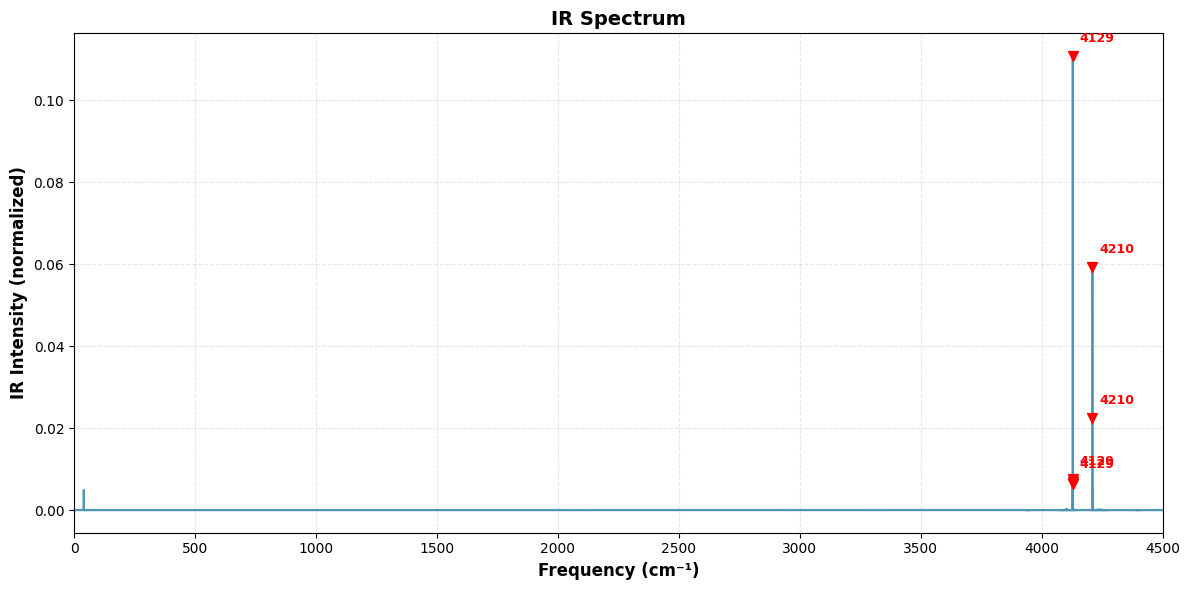

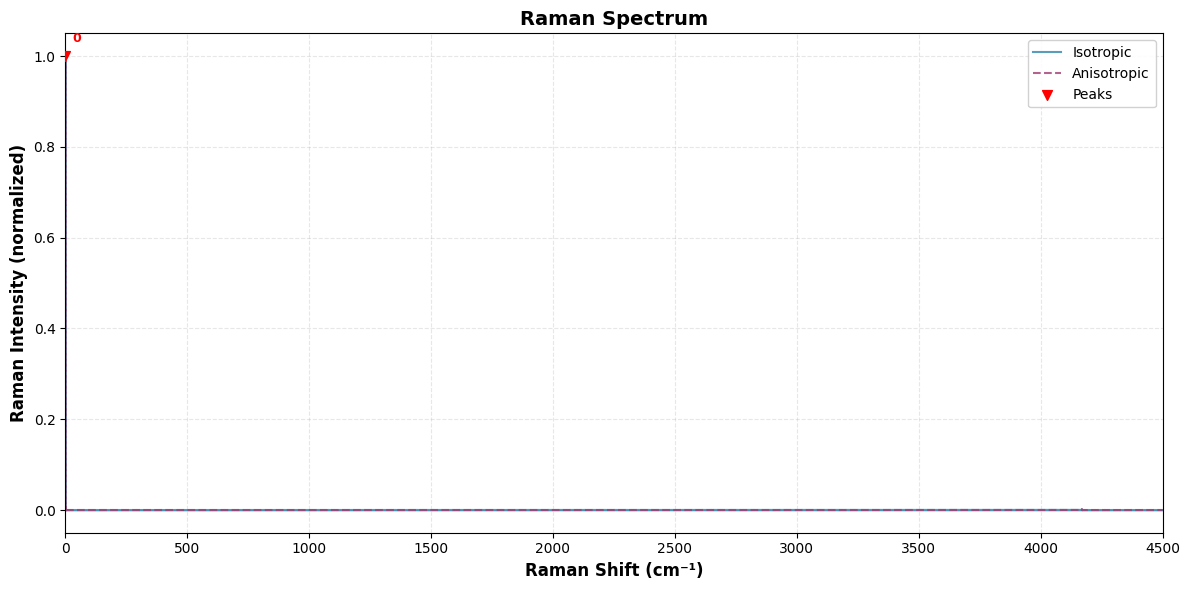

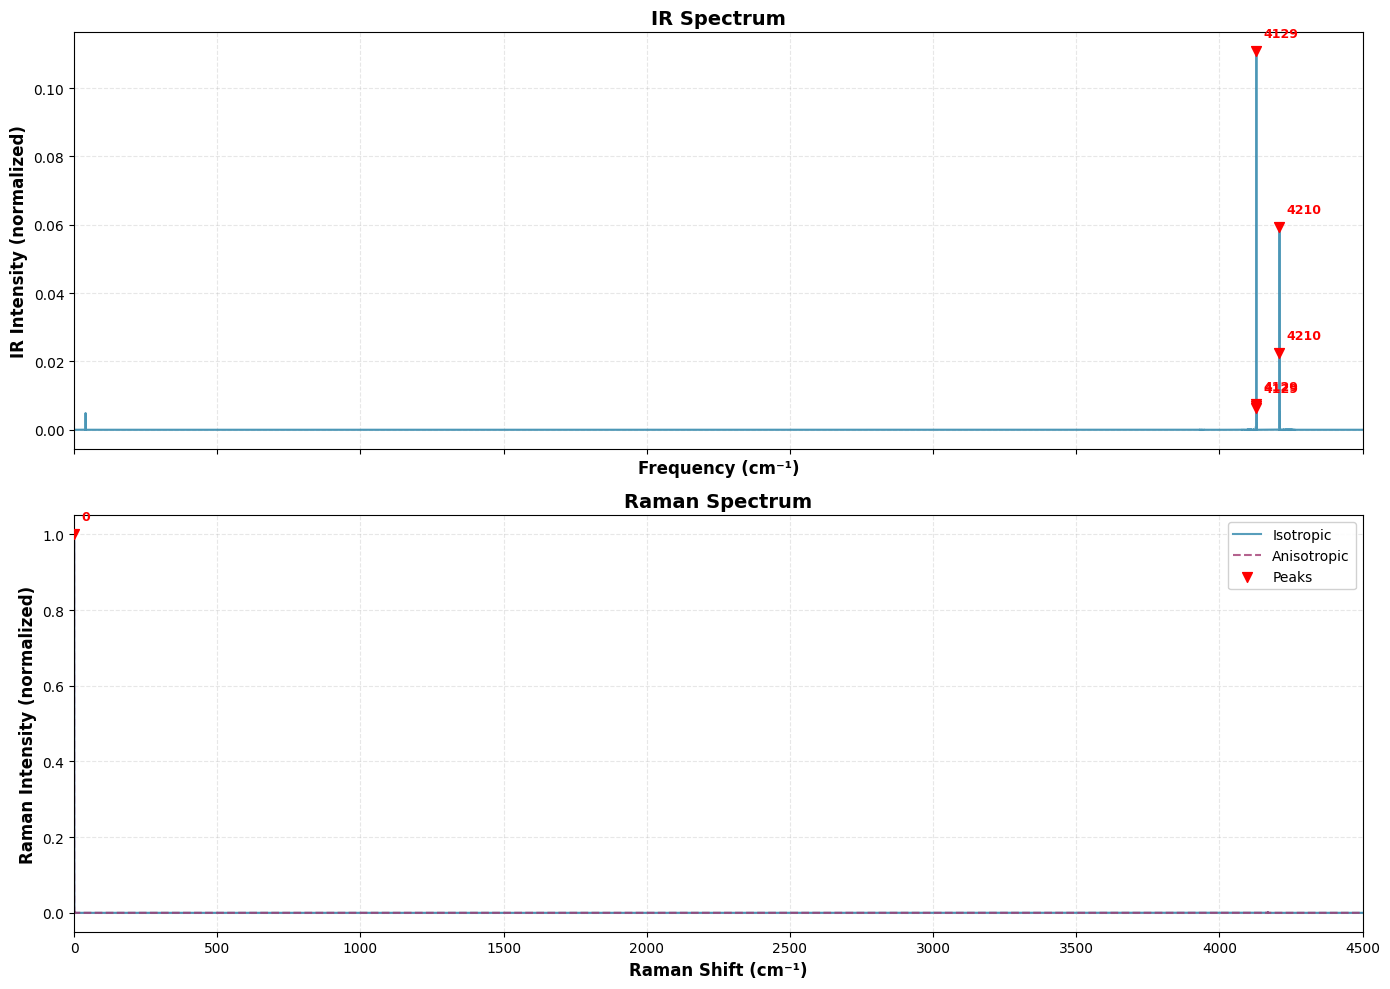

In [10]:
from pathlib import Path
from types import SimpleNamespace
# from plot_ir_raman import main_with_args

args = SimpleNamespace(
    input=Path("../ir_raman.npz").resolve(),
    output_dir=Path("./plots"),
    freq_range=[0, 4500],
    no_peaks=False,
    peak_threshold=0.05,
    dpi=300,
)

outdata = main(args)

In [29]:
3511553/2

1755776.5

In [113]:
outdata["ir_frequencies"][1::2]/2, outdata["ir_autocorrelation"][:]

(array([4.74952521e-03, 1.42485756e-02, 2.37476261e-02, ...,
        1.66781810e+04, 1.66781905e+04, 1.66782000e+04], shape=(1755776,)),
 array([ 2.68434500e-04, -5.19466277e-07, -1.20082083e-06, ...,
         1.19076835e-05, -4.54982122e-06, -8.30243031e-06],
       shape=(1755776,)))

(-1e-05, 1e-05)

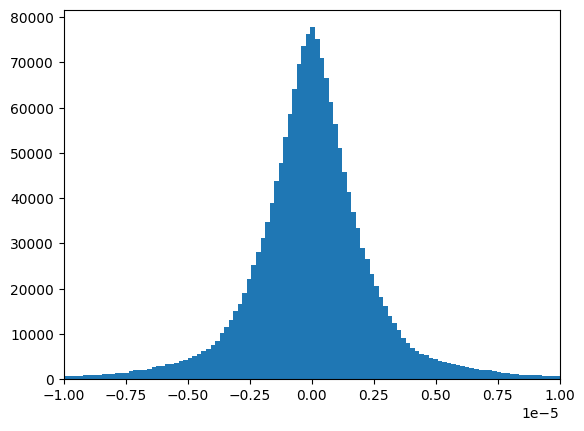

In [153]:
plt.hist(outdata["ir_autocorrelation"], bins=2000)
plt.xlim(-0.00001, 0.00001)

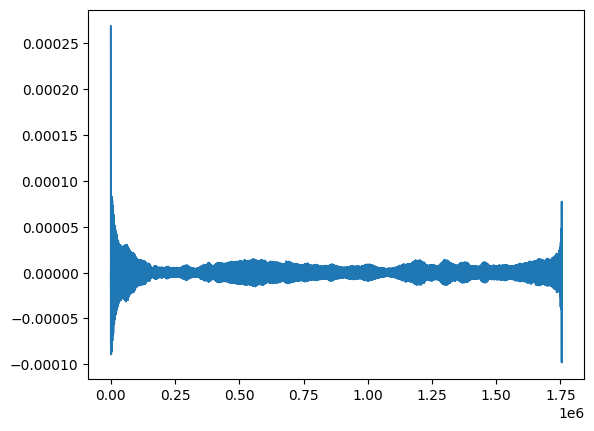

In [114]:
plt.plot(outdata["ir_autocorrelation"])

In [115]:
outdata.keys()

dict_keys(['timestep', 'temperature', 'n_frames', 'ir_frequencies', 'ir_intensity', 'ir_autocorrelation', 'raman_frequencies', 'raman_intensity_isotropic', 'raman_intensity_anisotropic', 'raman_laser_frequency'])

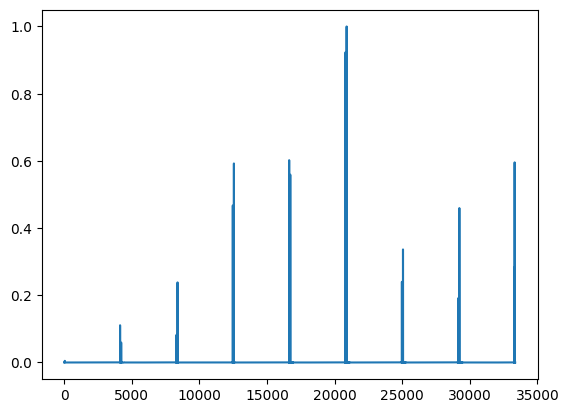

In [116]:
plt.plot(outdata["ir_frequencies"], outdata["ir_intensity"][:])
# plt.xlim(0,3500)
# plt.ylim(0,0.0001)

In [137]:
NNN = 1000000

inte = apply_ir_corrections(outdata["ir_frequencies"][1000:NNN]/2, outdata["ir_intensity"][1000:NNN])

In [138]:
inte

array([2.95044379e+05, 3.00353422e+05, 2.98195047e+05, ...,
       1.03583589e-01, 1.13635831e-01, 1.75093013e-01], shape=(999000,))

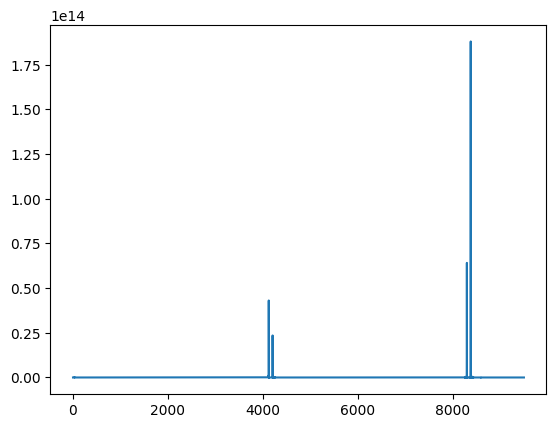

In [139]:
plt.plot(outdata["ir_frequencies"][1000:NNN], inte)
# plt.xlim(0,4500)
# plt.ylim(0,0.000001)

(0.0, 4500.0)

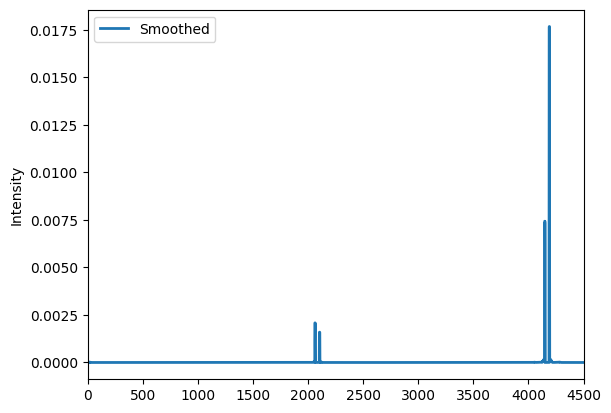

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Running average smoothing
window_size = 1000  # adjust for desired smoothness
window = np.ones(window_size) / window_size
y_smooth = np.convolve(inte / inte.max(), window, mode='same')

# Plot
# plt.plot(x, y, label='Original')
plt.plot(outdata["ir_frequencies"][1000:NNN]/2, y_smooth[:], label='Smoothed', linewidth=2)
plt.legend()
# plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.xlim(0,4500)



(0.0, 4500.0)

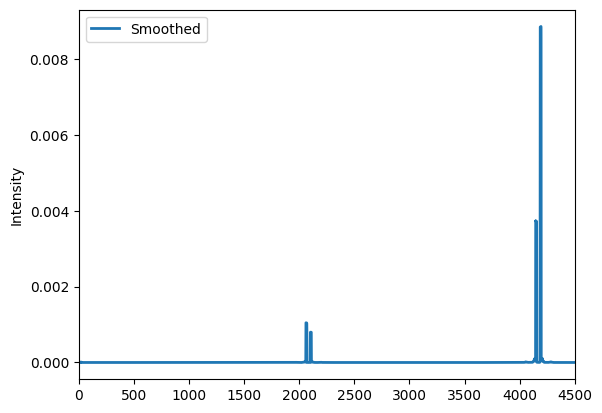

In [150]:
import numpy as np
import matplotlib.pyplot as plt

# Running average smoothing
window_size = 2000  # adjust for desired smoothness
window = np.ones(window_size) / window_size
y_smooth = np.convolve(inte / inte.max(), window, mode='same')

# Plot
# plt.plot(x, y, label='Original')
plt.plot(outdata["ir_frequencies"][1000:NNN]/2, y_smooth[:], label='Smoothed', linewidth=2)
plt.legend()
# plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.xlim(0,4500)
# plt.ylim(0,0.00000001)

(0.0, 1e-08)

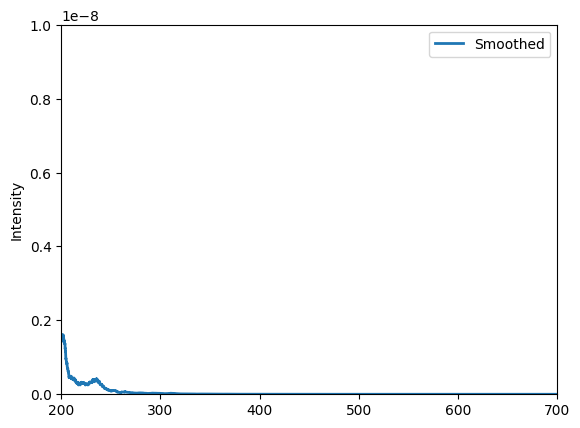

In [148]:
# Running average smoothing
window_size = 1000  # adjust for desired smoothness
window = np.ones(window_size) / window_size
y_smooth = np.convolve(inte / inte.max(), window, mode='same')

# Plot
# plt.plot(x, y, label='Original')
plt.plot(outdata["ir_frequencies"][1000:NNN]/2, y_smooth[:], label='Smoothed', linewidth=2)
plt.legend()
# plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.xlim(200,700)
plt.ylim(0,0.00000001)